## ✅ 전체 알고리즘 개요

### 입력

* 사용자가 선택한 관광지, 숙소 위치
* 선호 설정 (예: 도보 우선 / 대중교통 우선 / 최소 환승 / 최대 관광지 수 등)

### 출력

* 시간 및 거리 기준의 최적 경로 (숙소 → 관광지들 경유 → 숙소 또는 종착지)
* 각 이동 구간의 교통 수단, 예상 소요 시간, 거리

### **1단계. 사용자 입력 처리**
Input:
- 숙소 위치 L0
- 사용자가 선택한 관광지 리스트 [P1, P2, ..., Pn]
- 사용자 선호도 설정 (ex. 도보 우선, 교통 혼잡 피하기 등)

In [3]:
import pandas as pd

In [4]:
관광_3요소 = pd.read_csv('관광_3요소_수정.csv')
숙박 = pd.read_csv('숙박_종합친환경점수.csv')
식음 = pd.read_csv('식음_탄소배출량_매핑.csv')

In [5]:
숙소 = {'name': 'T호텔', 'lat': 35.137569, 'lon': 129.066685}
관광지 = [
    {'name': '민락수변공원', 'lat': 35.155907, 'lon': 129.13435},
    {'name': '다대포해수욕장', 'lat': 35.046382, 'lon': 128.968007},
    {'name': '몰운대', 'lat': 35.046382, 'lon': 128.968007},
]

In [6]:
import pandas as pd
import numpy as np

In [7]:
!pip install folium

In [8]:
!pip install osmnx networkx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.5/100.5 kB 2.2 MB/s eta 0:00:00


최소 이동 거리: 47799.57 m


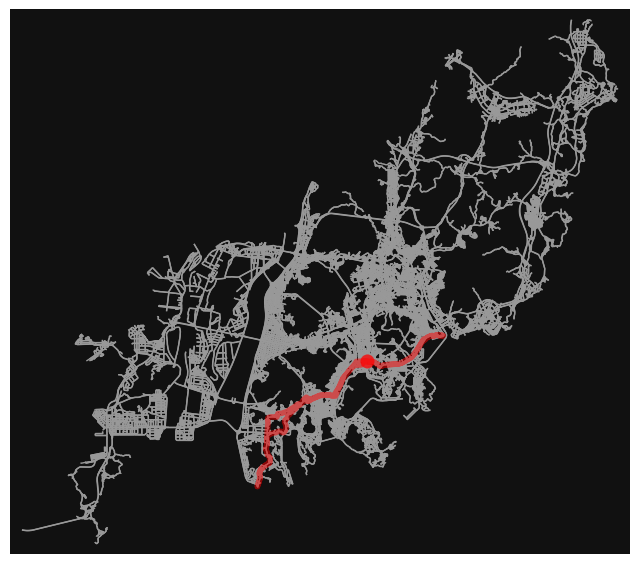

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [9]:
import osmnx as ox
import networkx as nx
import itertools

# 1. 부산 도로망 로딩
G = ox.graph_from_place("Busan, South Korea", network_type='drive')

# 2. 위치 정보 입력
숙소 = {'name': 'T호텔', 'lat': 35.137569, 'lon': 129.066685}
관광지 = [
    {'name': '민락수변공원', 'lat': 35.155907, 'lon': 129.13435},
    {'name': '다대포해수욕장', 'lat': 35.046382, 'lon': 128.968007},
    {'name': '몰운대', 'lat': 35.046382, 'lon': 128.968007},
]

# 3. 위치별 노드 매핑
def get_node(loc):
    return ox.distance.nearest_nodes(G, loc['lon'], loc['lat'])

숙소['node'] = get_node(숙소)
for g in 관광지:
    g['node'] = get_node(g)

# 4. 순열 생성 및 최적 경로 탐색
min_dist = float('inf')
best_route = []

for perm in itertools.permutations(관광지):
    route_nodes = [숙소] + list(perm) + [숙소]
    total_dist = 0
    path_nodes = []

    for i in range(len(route_nodes) - 1):
        try:
            path = nx.shortest_path(G, route_nodes[i]['node'], route_nodes[i+1]['node'], weight='length')
            dist = nx.shortest_path_length(G, route_nodes[i]['node'], route_nodes[i+1]['node'], weight='length')
        except nx.NetworkXNoPath:
            dist = float('inf')
            path = []
        total_dist += dist
        path_nodes += path[:-1]  # 중복 노드 제거용

    path_nodes.append(route_nodes[-1]['node'])  # 마지막 노드 추가

    if total_dist < min_dist:
        min_dist = total_dist
        best_route = path_nodes

print(f"최소 이동 거리: {min_dist:.2f} m")

# 5. 지도 시각화
ox.plot_graph_route(G, best_route, route_linewidth=4, node_size=0)


### **2단계. 주변 관광지 및 POI 후보 자동 추천**

> **평가 요소:**

* POI\_선호도 = 사용자 취향 유사도 기반 점수 (ex. 자연, 쇼핑, 미술관 등)
* 접근성 = 대중교통 정류장까지의 거리 + 도보 연결성

In [10]:
from shapely.geometry import Point, LineString
import pandas as pd
import geopandas as gpd
import osmnx as ox

# 1. 경로 노드를 위경도로 변환
route_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in best_route]  # (lat, lon)

# 2. 경로를 LineString으로 표현 (GeoPandas 사용)
route_line = LineString(route_coords)
route_buffer = route_line.buffer(0.05)  # 대략 300m (위경도 기준, 지역에 따라 조정 필요)

# 3. 관광지 GeoDataFrame 생성
관광_3요소_gdf = gpd.GeoDataFrame(
    관광_3요소,
    geometry=gpd.points_from_xy(관광_3요소['LONGITUDE'], 관광_3요소['LATITUDE']),
    crs="EPSG:4326"
)

# 4. 식음 GeoDataFrame 생성
식음_gdf = gpd.GeoDataFrame(
    식음,
    geometry=gpd.points_from_xy(식음['X'], 식음['Y']),
    crs="EPSG:4326"
)

# 5. 경로 버퍼 내 포함되는 POI 필터링
추천_관광지 = 관광_3요소_gdf[관광_3요소_gdf.geometry.within(route_buffer)]
추천_식당 = 식음_gdf[식음_gdf.geometry.within(route_buffer)]

# 6. 결과 출력
print("📍 경로 주변 관광지 추천:")
print(추천_관광지[['LOC_NM']].drop_duplicates().head(10))

print("\n🍽️ 경로 주변 식당 추천:")
print(추천_식당[['이름']].drop_duplicates().head(10))


📍 경로 주변 관광지 추천:
Empty DataFrame
Columns: [LOC_NM]
Index: []

🍽️ 경로 주변 식당 추천:
Empty DataFrame
Columns: [이름]
Index: []


In [11]:
from shapely.geometry import Point, LineString
import geopandas as gpd

# 1. 경로 좌표를 LineString으로 변환
route_coords = [(G.nodes[node]['x'], G.nodes[node]['y']) for node in best_route]  # (lon, lat)
route_line = LineString(route_coords)

# 2. GeoSeries로 감싸기
route_gdf = gpd.GeoSeries([route_line], crs="EPSG:4326")

# 3. 거리 기반 버퍼를 위해 UTM 또는 EPSG:5181로 투영
route_gdf_proj = route_gdf.to_crs(epsg=5181)  # UTM-K for Korea
buffered = route_gdf_proj.buffer(300)  # 300 meters
buffered = buffered.to_crs(epsg=4326)  # 다시 WGS84로 복귀

# 4. 관광지/식당 데이터 준비
관광_3요소_gdf = gpd.GeoDataFrame(
    관광_3요소,
    geometry=gpd.points_from_xy(관광_3요소['LONGITUDE'], 관광_3요소['LATITUDE']),
    crs="EPSG:4326"
)

식음_gdf = gpd.GeoDataFrame(
    식음,
    geometry=gpd.points_from_xy(식음['X'], 식음['Y']),
    crs="EPSG:4326"
)

# 5. 추천 POI 필터링: 각 점이 buffer polygon 내부에 있는지 확인
추천_관광지 = 관광_3요소_gdf[관광_3요소_gdf.geometry.within(buffered.iloc[0])]
추천_식당 = 식음_gdf[식음_gdf.geometry.within(buffered.iloc[0])]

# 6. 출력
print("📍 경로 주변 관광지 추천:")
print(추천_관광지[['LOC_NM']].drop_duplicates().head(10))

print("\n🍽️ 경로 주변 식당 추천:")
print(추천_식당[['이름']].drop_duplicates().head(10))


📍 경로 주변 관광지 추천:
         LOC_NM
16     광안리 해수욕장
18  다대포 꿈의 낙조분수
20      다대포해수욕장
21          몰운대
26       민락수변공원

🍽️ 경로 주변 식당 추천:
           이름
150     에이엠공팔
151      콩지니빵
152     현대칼국수
153  제주은희네해장국
155       옥선집
156     하삼동커피
157      뚜레쥬르
159     충남뚝배기
160      미정식당
163      부식가게


In [12]:
관광_3요소.iloc[26]

,26
Unnamed: 0.1,26
Unnamed: 0,26
LOC_NM,민락수변공원
LATITUDE,35.155907
LONGITUDE,129.13435
관광_지하철,1
관광_숙박,47
관광_식음,40
관광_버스,78


In [13]:
식음.iloc[163]

,163
Unnamed: 0,163
이름,부식가게
X,129.037451
Y,35.111237
대분류,밥류
탄소배출량,0.414


In [14]:
import folium

# 1. 지도 생성 (숙소 중심)
m = folium.Map(location=[숙소['lat'], 숙소['lon']], zoom_start=12)

# 2. 최적 경로 표시
route_coords = [(G.nodes[node]['y'], G.nodes[node]['x']) for node in best_route]
folium.PolyLine(route_coords, color='blue', weight=5, tooltip="최적 경로").add_to(m)

# 3. 숙소 마커 (파란색)
folium.Marker(
    location=[숙소['lat'], 숙소['lon']],
    popup='숙소: ' + 숙소['name'],
    icon=folium.Icon(color='blue', icon='home')
).add_to(m)

# 4. 추천 관광지 5개만 마커 표시 (초록색)
관광지_마커정보 = {
    '광안리 해수욕장': (35.15318, 129.11887),
    '다대포 꿈의 낙조분수': (35.046382, 128.968007),
    # '다대포해수욕장': (35.046382, 128.968007),
    # '몰운대': (35.046382, 128.968007),
    # '민락수변공원': (35.155907, 129.13435),
}

for name, (lat, lon) in 관광지_마커정보.items():
    folium.Marker(
        location=[lat, lon],
        popup='관광지: ' + name,
        icon=folium.Icon(color='green', icon='flag')
    ).add_to(m)

# 5. 추천 식당 10개 마커 표시 (빨간색)
식당_마커정보 = {
    '에이엠공팔': (35.109853, 129.036983),
    '콩지니빵': (35.1112, 129.037582),
    '현대칼국수': (35.111552, 129.037521),
    '제주은희네해장국': (35.11138, 129.037639),
    '옥선집': (35.110373, 129.037174),
    '하삼동커피': (35.1555, 129.037286),
    # '뚜레쥬르': (35.1562, 129.1355),
    '충남뚝배기': (35.110985, 129.037382),
    '미정식당': (35.110841, 129.037336),
    '부식가게': (35.111237, 129.037451),
}

for name, (lat, lon) in 식당_마커정보.items():
    folium.Marker(
        location=[lat, lon],
        popup='식당: ' + name,
        icon=folium.Icon(color='red', icon='cutlery')
    ).add_to(m)

# 6. 저장 및 출력
m.save("최적경로_관광지_식당지도.html")
m  # Jupyter Notebook이면 이 코드로 바로 보여집니다


In [15]:
# 1. 사용할 식당 이름 목록
식당_이름_목록 = list(식당_마커정보.keys())

# 2. 이름 기준 필터링
선택_식당_df = 식음[식음['이름'].isin(식당_이름_목록)]

# 3. 중복 제거 (이름이 동일한 경우 첫 번째만 유지)
중복제거_식당_df = 선택_식당_df.drop_duplicates(subset='이름', keep='first')

# 4. 탄소배출량 기준 정렬
정렬된_식당_df = 중복제거_식당_df.sort_values(by='탄소배출량', ascending=True)

# 5. 결과 출력
print(정렬된_식당_df[['이름', '탄소배출량']])


           이름  탄소배출량
156     하삼동커피  0.180
151      콩지니빵  0.414
155       옥선집  0.414
160      미정식당  0.414
163      부식가게  0.414
152     현대칼국수  1.300
150     에이엠공팔  2.600
153  제주은희네해장국  2.736
159     충남뚝배기  5.933


In [16]:
버스 = pd.read_csv('버스정류장_좌표.csv')
지하철 = pd.read_csv('지하철역_좌표.csv')

### **3단계. 경로 그래프 구축**

* 후보지들 간 이동 경로를 **그래프로 구성**
  노드: 장소
  엣지: 도보 또는 대중교통 기반 경로

  > **교통 비용 계산:**

* 도보: 거리 / 평균 속도 (분/km)
* 대중교통: 실시간/정적 교통망 데이터에서 소요 시간 추정

  * 환승 시 `penalty = α * 환승횟수 + β * 대기시간`

### **4단계. 최적 경로 탐색 (TSP 변형 + 교통비용 최적화)**

* 숙소를 시작점으로 하는 순회 또는 도착지 포함 경로 탐색
* **우선순위 기반 탐색 알고리즘** 사용: `A*`, `Dijkstra`, `Beam Search`, `Genetic Algorithm` 등 가능

### **5단계. 결과 출력 및 시각화**
Output:
- 추천 경로 순서 (숙소 → 관광지 1 → … → 관광지 N)
- 각 이동 구간의 수단, 소요 시간, 거리
- 전체 여행 소요 시간, 친환경 점수 요약
- 지도 상 시각화 (folium 또는 leaflet 기반 출력)

지금 나한테 대중교통 api가 없어서 임의로 내가 최적경로를 계산하는 방식을 알려줄게.  
1) 지하철역은 서로 직선으로 이어져 있다고 가정한다.  
2) 버스정류장은 osm상의 도로교통망으로 이어져있다.  
3) 도보도 도로교통망으로 이동한다고 가정한다.  
4) folium으로 지도로 표시할 때 각 경우의 경로 색깔을 달리한다.  
5) 버스, 지하철로 이동하지 않는 구간은 도보로 이동한다고 가정한다.  
예를 들어 내가 숙소->관광지1->관광지2->관광지3->숙소 의 여정의 최적경로를 계산한다고 할 때, 숙소->관광지1 의 경로
관광지1->관광지2 의 경로
관광지2->관광지3 의 경로
관광지3->숙소 의 경로 상에서 들리는 모든 버스정류장 이름과 지하철역 이름을 알려주면 이를 이용해 최적경로를 계산하는 알고리즘을 짜줘.
참고로 버스정류장의 이름, 위경도와 지하철역의 이름, 위경도를 포함하는 데이터셋을 이미 가지고 있어. 해당 csv의 이름은 버스정류장.csv, 지하철.csv야.

In [17]:


import pandas as pd
import osmnx as ox
import networkx as nx
import folium
from shapely.geometry import LineString
from geopy.distance import geodesic

# 1. 데이터 불러오기
지하철 = pd.read_csv("지하철.csv")  # columns: 역명, 위도, 경도
버스정류장 = pd.read_csv("버스정류장_좌표.csv")  # columns: 이름, 위도LATITUDE, 경도LONGITUDE

# 2. OSM 도로망 로딩
G = ox.graph_from_place("Busan, South Korea", network_type='drive')

# 3. 지하철 그래프 구성 (직선 거리 기반)
# 경도: TZ_AREA_XCRDT_VAL
# 위도: TZ_AREA_YCRDT_VAL
subway_G = nx.Graph()
for i, row_i in 지하철.iterrows():
    for j, row_j in 지하철.iterrows():
        if i < j:
            coord_i = (row_i['위도'], row_i['경도'])
            coord_j = (row_j['위도'], row_j['경도'])
            dist = geodesic(coord_i, coord_j).meters
            subway_G.add_edge(row_i['역명'], row_j['역명'], weight=dist)

# 4. 주요 위치 (숙소 및 관광지들)
경유지 = [
    {"name": "숙소", "lat": 35.137569, "lon": 129.066685},
    {"name": "민락수변공원", "lat": 35.155907, "lon": 129.13435},
    {"name": "다대포해수욕장", "lat": 35.046382, "lon": 128.968007},
    {"name": "몰운대", "lat": 35.0415, "lon": 128.9605},
    {"name": "숙소", "lat": 35.137569, "lon": 129.066685}
]

# 5. 경유 구간 분석
all_routes = []
for i in range(len(경유지) - 1):
    start = 경유지[i]
    end = 경유지[i + 1]

    # (1) 도보 경로
    start_node = ox.distance.nearest_nodes(G, start['lon'], start['lat'])
    end_node = ox.distance.nearest_nodes(G, end['lon'], end['lat'])
    walk_path = nx.shortest_path(G, start_node, end_node, weight='length')
    walk_dist = nx.shortest_path_length(G, start_node, end_node, weight='length')

    # (2) 가장 가까운 지하철역 → A* 경로 탐색
    def 가장가까운역(lat, lon):
        return 지하철.loc[
            지하철.apply(lambda row: geodesic((lat, lon), (row['위도'], row['경도'])).meters, axis=1).idxmin()
        ]['역명']

    출발역 = 가장가까운역(start['lat'], start['lon'])
    도착역 = 가장가까운역(end['lat'], end['lon'])
    subway_path = nx.shortest_path(subway_G, 출발역, 도착역, weight='weight')
    subway_dist = nx.shortest_path_length(subway_G, 출발역, 도착역, weight='weight')

    # (3) 버스 경로 (출발/도착 지점에서 가장 가까운 정류장 기준)
    def 가장가까운정류장(lat, lon):
        return 버스정류장.loc[
            버스정류장.apply(lambda row: geodesic((lat, lon), (row['위도'], row['경도'])).meters, axis=1).idxmin()
        ]

    출발정류장 = 가장가까운정류장(start['lat'], start['lon'])
    도착정류장 = 가장가까운정류장(end['lat'], end['lon'])
    출발노드 = ox.distance.nearest_nodes(G, 출발정류장['경도'], 출발정류장['위도'])
    도착노드 = ox.distance.nearest_nodes(G, 도착정류장['경도'], 도착정류장['위도'])

    try:
        bus_path = nx.shortest_path(G, 출발노드, 도착노드, weight='length')
        bus_dist = nx.shortest_path_length(G, 출발노드, 도착노드, weight='length')
    except:
        bus_path, bus_dist = None, float('inf')

    # (4) 최단 경로 선택
    방법 = min(
        [('walk', walk_dist, walk_path)],
        [('subway', subway_dist, subway_path)],
        [('bus', bus_dist, bus_path)],
        key=lambda x: x[1]
    )

    all_routes.append((방법[0], 방법[2]))

# 6. 지도 시각화
m = folium.Map(location=[경유지[0]['lat'], 경유지[0]['lon']], zoom_start=12)

color_map = {'walk': 'blue', 'bus': 'red', 'subway': 'green'}

for method, path in all_routes:
    if method == 'subway':
        # subway path는 역 이름으로 되어 있음 → 좌표로 변환
        coords = [(지하철.loc[지하철['역명'] == name, '위도'].values[0],
                   지하철.loc[지하철['역명'] == name, '경도'].values[0]) for name in path]
    else:
        coords = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in path]

    folium.PolyLine(coords, color=color_map[method], weight=4, tooltip=method).add_to(m)

# 마커 찍기
for p in 경유지:
    folium.Marker(location=[p['lat'], p['lon']], popup=p['name'], icon=folium.Icon(color='black')).add_to(m)

m.save("혼합_교통_최적경로.html")


KeyError: '위도'

In [22]:
# 버스정류장 COLUMN 명을 지하철과 맞추기
버스정류장.rename(columns={'LATITUDE': '위도', 'LONGITUDE': '경도'}, inplace=True)

In [24]:
버스정류장.head()

,STN_CD,경도,위도,STN_NM,LOAD_DATE
0,2600002,128.96160,35.04934,다대포,20220104
1,2600002,128.96160,35.04934,다대포,20231208
2,2600003,128.96552,35.04822,다대포해수욕장역,20220104
3,2600003,128.96552,35.04822,다대포해수욕장역,20231208
4,2600004,128.96751,35.05007,몰운대아파트,20220104


In [54]:
import pandas as pd
import osmnx as ox
import networkx as nx
import folium
from shapely.geometry import LineString
from geopy.distance import geodesic

######################## 숙소->1
# 1. 데이터 불러오기
지하철 = pd.read_csv("지하철.csv")
버스 = pd.read_csv("버스정류장_좌표.csv")

# 2. 전처리 (컬럼 이름 정리)
지하철.rename(columns={'TZ_AREA_XCRDT_VAL': '경도', 'TZ_AREA_YCRDT_VAL': '위도'}, inplace=True)
버스.rename(columns={'LATITUDE': '위도', 'LONGITUDE': '경도'}, inplace=True)

# 3. 출발지/목적지 좌표
출발지 = [35.137569, 129.066685]
목적지 = [35.155907, 129.13435]
# 지도 객체 생성(여기서만!!)
m = folium.Map(location=출발지, zoom_start=13)
# 4. 방문할 지하철역, 버스정류장 리스트
# 지하철역은 가운뎃점:·
# 버스정류장은 온점:.
지하철역_리스트 = ['문현', '지게골', '못골', '대연', '경성대·부경대', '남천', '금련산', '광안', '수영', '민락']
버스정류장_리스트 = ['수영현대아파트.민락역', '수영만아이파크', '센텀비치푸르지오', '롯데캐슬아파트', '민락수변공원']

# 5. OSM 도로망 로드 (도보 기준)
G = ox.graph_from_place("Busan, South Korea", network_type='walk')
색상 = {'도보': 'green', '버스': 'red', '지하철': 'blue'}
# 6. 거리 계산 함수
def haversine_dist(p1, p2):
    return geodesic(p1, p2).meters

# 7. 이름이 같은 후보 중 가장 가까운 하나를 선택
def 가장가까운_좌표(이름, df, 현재위치, 이름컬럼):
    후보들 = df[df[이름컬럼] == 이름]
    if 후보들.empty:
        print(f"경고: {이름}을(를) 찾을 수 없습니다.")
        return None
    후보들 = 후보들.copy()
    후보들['거리'] = 후보들.apply(lambda row: haversine_dist(현재위치, (row['위도'], row['경도'])), axis=1)
    return 후보들.sort_values('거리').iloc[0]

# 8. 도로망 또는 직선 연결 함수
def 연결_경로(시작점, 끝점, 타입):
    if 시작점 == 끝점 or None in 시작점 or None in 끝점:
        return []
    if 타입 in ['도보', '버스']:
        try:
            n1 = ox.distance.nearest_nodes(G, 시작점[1], 시작점[0])
            n2 = ox.distance.nearest_nodes(G, 끝점[1], 끝점[0])
            path = nx.shortest_path(G, n1, n2, weight='length')
            return [(G.nodes[n]['y'], G.nodes[n]['x']) for n in path]
        except:
            pass
    # 지하철은 직선 연결
    return [시작점, 끝점]

# 9. 경로 생성 함수 (경로순서 인자로 받음)
def 경로_생성(출발지, 목적지, 경로순서):
    전체경로 = []
    현재위치 = 출발지
    이전타입 = None

    for 타입, 이름리스트 in 경로순서:
        for 이름 in 이름리스트:
            if 타입 == '지하철':
                지점 = 가장가까운_좌표(이름, 지하철, 현재위치, '역명')
            else:
                지점 = 가장가까운_좌표(이름, 버스, 현재위치, 'STN_NM')
            if 지점 is None:
                continue

            목적지점 = (지점['위도'], 지점['경도'])

            # 이전 타입과 현재 타입이 다르면 도보 경로 추가
            if 이전타입 and 이전타입 != 타입:
                도보경로 = 연결_경로(현재위치, 목적지점, '도보')
                전체경로.append(('도보', 도보경로))

            # 현재 타입의 경로 추가
            좌표리스트 = 연결_경로(현재위치, 목적지점, 타입)
            전체경로.append((타입, 좌표리스트))
            현재위치 = 목적지점
            이전타입 = 타입

    # 마지막 도보 구간 (현재위치 → 최종 목적지)
    마지막구간 = 연결_경로(현재위치, 목적지, '도보')
    전체경로.append(('도보', 마지막구간))
    return 전체경로

# 10. 사용자로부터 경로 순서 입력 받기 (예: "버스,지하철" 또는 "지하철,버스")
# user_order = input("경로 순서를 입력하세요 (예: '버스,지하철' 또는 '지하철,버스'): ").replace(" ", "")
# order_list = user_order.split(',')

경로순서 = [('지하철', 지하철역_리스트),('버스', 버스정류장_리스트)]
# for o in order_list:
#     if o == '지하철':
#         경로순서.append(('지하철', 지하철역_리스트))
#     elif o == '버스':
#         경로순서.append(('버스', 버스정류장_리스트))
#     else:
#         print(f"알 수 없는 교통수단: {o}")

# 11. 지도 객체 생성
# m = folium.Map(location=출발지, zoom_start=13)
# 색상 = {'도보': 'green', '버스': 'red', '지하철': 'blue'}

# 12. 경로 생성 및 지도에 그리기
전체경로 = 경로_생성(출발지, 목적지, 경로순서)
for 타입, 경로 in 전체경로:
    if len(경로) >= 2:
        folium.PolyLine(경로, color=색상[타입], weight=5, opacity=0.8, tooltip=타입).add_to(m)

# 13. 시작/도착 마커 추가
folium.Marker(
    location=출발지,
    popup='출발지',
    icon=folium.Icon(color='red', icon='hotel', prefix='fa')
).add_to(m)

folium.Marker(
    location=목적지,
    popup='목적지',
    icon=folium.Icon(color='blue', icon='flag', prefix='fa')
).add_to(m)

################################# 숙소->1
################################# 1->2

# # 1. 데이터 불러오기
# 지하철 = pd.read_csv("지하철.csv")
# 버스 = pd.read_csv("버스정류장_좌표.csv")

# # 2. 전처리 (컬럼 이름 정리)
# 지하철.rename(columns={'TZ_AREA_XCRDT_VAL': '경도', 'TZ_AREA_YCRDT_VAL': '위도'}, inplace=True)
# 버스.rename(columns={'LATITUDE': '위도', 'LONGITUDE': '경도'}, inplace=True)

# 3. 출발지/목적지 좌표
출발지 = [35.1559, 129.13435]
목적지 = [35.04652, 128.96283]

# 4. 방문할 지하철역, 버스정류장 리스트
버스정류장_리스트 = [
    "민락수변공원", "롯데캐슬아파트", "센텀비치푸르지오", "민락교", "MBC방송국", "민락동골목시장", "광안농협앞",
    "광안리해수욕장", "광안리카페거리입구", "광일맨션", "수영구청", "KBS방송국", "대남교차로.남천역",
    "경성대.부경대역", "경성대학교", "대연역", "못골시장", "남구청.못골역", "대연고개", "지게골역",
    "문현교차로", "범일교", "부산진성공원", "부산진시장", "봉생병원", "부산진역"
]

지하철역_리스트 = [
    "부산진", "초량", "부산역", "중앙", "남포", "자갈치", "토성", "동대신", "서대신", "대티",
    "괴정", "사하", "당리", "하단", "신평", "동매", "장림", "신장림", "다대포항", "다대포해수욕장"
]


# 5. OSM 도로망 로드 (도보 기준)
# G = ox.graph_from_place("Busan, South Korea", network_type='walk')

# # 6. 거리 계산 함수
# def haversine_dist(p1, p2):
#     return geodesic(p1, p2).meters

# # 7. 이름이 같은 후보 중 가장 가까운 하나를 선택
# def 가장가까운_좌표(이름, df, 현재위치, 이름컬럼):
#     후보들 = df[df[이름컬럼] == 이름]
#     if 후보들.empty:
#         print(f"경고: {이름}을(를) 찾을 수 없습니다.")
#         return None
#     후보들 = 후보들.copy()
#     후보들['거리'] = 후보들.apply(lambda row: haversine_dist(현재위치, (row['위도'], row['경도'])), axis=1)
#     return 후보들.sort_values('거리').iloc[0]

# # 8. 도로망 또는 직선 연결 함수
# def 연결_경로(시작점, 끝점, 타입):
#     if 시작점 == 끝점 or None in 시작점 or None in 끝점:
#         return []
#     if 타입 in ['도보', '버스']:
#         try:
#             n1 = ox.distance.nearest_nodes(G, 시작점[1], 시작점[0])
#             n2 = ox.distance.nearest_nodes(G, 끝점[1], 끝점[0])
#             path = nx.shortest_path(G, n1, n2, weight='length')
#             return [(G.nodes[n]['y'], G.nodes[n]['x']) for n in path]
#         except:
#             pass
#     # 지하철은 직선 연결
#     return [시작점, 끝점]

# # 9. 경로 생성 함수 (경로순서 인자로 받음)
# def 경로_생성(출발지, 목적지, 경로순서):
#     전체경로 = []
#     현재위치 = 출발지
#     for 타입, 이름리스트 in 경로순서:
#         for 이름 in 이름리스트:
#             if 타입 == '지하철':
#                 지점 = 가장가까운_좌표(이름, 지하철, 현재위치, '역명')
#             else:
#                 지점 = 가장가까운_좌표(이름, 버스, 현재위치, 'STN_NM')
#             if 지점 is None:
#                 continue
#             목적지점 = (지점['위도'], 지점['경도'])
#             좌표리스트 = 연결_경로(현재위치, 목적지점, 타입)
#             전체경로.append((타입, 좌표리스트))
#             현재위치 = 목적지점
#     # 마지막 도보 구간
#     좌표리스트 = 연결_경로(현재위치, 목적지, '도보')
#     전체경로.append(('도보', 좌표리스트))
#     return 전체경로

# 10. 사용자로부터 경로 순서 입력 받기 (예: "버스,지하철" 또는 "지하철,버스")
# user_order = input("경로 순서를 입력하세요 (예: '버스,지하철' 또는 '지하철,버스'): ").replace(" ", "")
# order_list = user_order.split(',')

# 경로순서 = [('버스',버스정류장_리스트),('지하철',지하철역_리스트)]
# for o in order_list:
#     if o == '지하철':
#         경로순서.append(('지하철', 지하철역_리스트))
#     elif o == '버스':
#         경로순서.append(('버스', 버스정류장_리스트))
#     else:
#         print(f"알 수 없는 교통수단: {o}")

# 11. 지도 객체 생성
# m = folium.Map(location=출발지, zoom_start=13)
# 색상 = {'도보': 'green', '버스': 'red', '지하철': 'blue'}

# 12. 경로 생성 및 지도에 그리기
전체경로 = 경로_생성(출발지, 목적지, 경로순서)
for 타입, 경로 in 전체경로:
    if len(경로) >= 2:
        folium.PolyLine(경로, color=색상[타입], weight=5, opacity=0.8, tooltip=타입).add_to(m)

# 13. 시작/도착 마커 추가
# folium.Marker(
#     location=출발지,
#     popup='출발지',
#     icon=folium.Icon(color='red', icon='hotel', prefix='fa')
# ).add_to(m)

folium.Marker(
    location=목적지,
    popup='목적지',
    icon=folium.Icon(color='blue', icon='flag', prefix='fa')
).add_to(m)

# # 14. 결과 저장
# m.save("최적경로_혼합교통_지도.html")
# m

# 순서 : 버스,지하철
##################################### 1->2
##################################### 2->3
# import osmnx as ox
# import networkx as nx
# import folium

# 1. 출발지와 목적지 정의
출발지 = [35.04652, 128.96283]
목적지 = [35.046381718, 128.9680068059]

# 2. OSM 도보 네트워크 로딩 (Busan 지역)
# G = ox.graph_from_point(출발지, dist=500, network_type='walk')

# 3. 가장 가까운 노드 찾기
출발노드 = ox.distance.nearest_nodes(G, 출발지[1], 출발지[0])
도착노드 = ox.distance.nearest_nodes(G, 목적지[1], 목적지[0])

# 4. 최단 경로 계산 (도보)
경로노드 = nx.shortest_path(G, 출발노드, 도착노드, weight='length')
경로좌표 = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in 경로노드]

# 5. folium 지도 객체 생성
# m = folium.Map(location=출발지, zoom_start=17)

# 6. 도보 경로 시각화
folium.PolyLine(경로좌표, color='green', weight=5, opacity=0.8, tooltip='도보').add_to(m)

# # 7. 시작 마커 (깃발)
# folium.Marker(
#     location=출발지,
#     icon=folium.Icon(color='blue', icon='flag', prefix='fa')
# ).add_to(m)

# 8. 도착 마커 (체커기 깃발)
folium.Marker(
    location=목적지,
    icon=folium.Icon(color='blue', icon='flag', prefix='fa')
).add_to(m)

# # 9. 저장
# m.save("최적경로_도보_다대포_몰운대.html")
# m

##################################### 2->3
##################################### 3->숙소

# # 1. 데이터 불러오기
# 지하철 = pd.read_csv("지하철.csv")
# 버스 = pd.read_csv("버스정류장_좌표.csv")

# # 2. 전처리 (컬럼 이름 정리)
# 지하철.rename(columns={'TZ_AREA_XCRDT_VAL': '경도', 'TZ_AREA_YCRDT_VAL': '위도'}, inplace=True)
# 버스.rename(columns={'LATITUDE': '위도', 'LONGITUDE': '경도'}, inplace=True)

# 3. 출발지/목적지 좌표
출발지 = [35.045764, 128.965251]
목적지 = [35.137569, 129.066685]

# 4. 방문할 지하철역, 버스정류장 리스트
지하철역_리스트 = [
    '다대포해수욕장', '다대포항', '신장림', '장림', '동매', '신평', '하단',
    '당리', '사하', '괴정', '대티', '서대신', '동대신', '토성', '자갈치',
    '남포', '중앙', '부산역', '초량', '부산진', '좌천', '범일'
    ]
버스정류장_리스트 = [
    '범일동국민은행', '눌원빌딩'
]

# 5. OSM 도로망 로드 (도보 기준)
# G = ox.graph_from_place("Busan, South Korea", network_type='walk')

# # 6. 거리 계산 함수
# def haversine_dist(p1, p2):
#     return geodesic(p1, p2).meters

# # 7. 이름이 같은 후보 중 가장 가까운 하나를 선택
# def 가장가까운_좌표(이름, df, 현재위치, 이름컬럼):
#     후보들 = df[df[이름컬럼] == 이름]
#     if 후보들.empty:
#         print(f"경고: {이름}을(를) 찾을 수 없습니다.")
#         return None
#     후보들 = 후보들.copy()
#     후보들['거리'] = 후보들.apply(lambda row: haversine_dist(현재위치, (row['위도'], row['경도'])), axis=1)
#     return 후보들.sort_values('거리').iloc[0]

# # 8. 도로망 또는 직선 연결 함수
# def 연결_경로(시작점, 끝점, 타입):
#     if 시작점 == 끝점 or None in 시작점 or None in 끝점:
#         return []
#     if 타입 in ['도보', '버스']:
#         try:
#             n1 = ox.distance.nearest_nodes(G, 시작점[1], 시작점[0])
#             n2 = ox.distance.nearest_nodes(G, 끝점[1], 끝점[0])
#             path = nx.shortest_path(G, n1, n2, weight='length')
#             return [(G.nodes[n]['y'], G.nodes[n]['x']) for n in path]
#         except:
#             pass
#     # 지하철은 직선 연결
#     return [시작점, 끝점]

# # 9. 경로 생성 함수 (경로순서 인자로 받음)
def 경로_생성(출발지, 목적지, 경로순서):
    전체경로 = []
    현재위치 = 출발지

    # 각 타입별로 이름 리스트 정리
    구간포인트 = {}
    for 타입, 이름리스트 in 경로순서:
        구간포인트[타입] = []
        for 이름 in 이름리스트:
            if 타입 == '지하철':
                지점 = 가장가까운_좌표(이름, 지하철, 출발지, '역명')
            else:
                지점 = 가장가까운_좌표(이름, 버스, 출발지, 'STN_NM')
            if 지점 is not None:
                구간포인트[타입].append((지점['위도'], 지점['경도']))

    # 도보1: 출발지 → 첫 지하철역
    if '지하철' in 구간포인트 and 구간포인트['지하철']:
        도보1 = 연결_경로(출발지, 구간포인트['지하철'][0], '도보')
        전체경로.append(('도보', 도보1))
        현재위치 = 구간포인트['지하철'][0]
    else:
        현재위치 = 출발지

    # 지하철 경로
    if '지하철' in 구간포인트:
        for i in range(len(구간포인트['지하철']) - 1):
            시작 = 구간포인트['지하철'][i]
            끝 = 구간포인트['지하철'][i + 1]
            선 = 연결_경로(시작, 끝, '지하철')
            전체경로.append(('지하철', 선))
        현재위치 = 구간포인트['지하철'][-1]

    # 도보2: 마지막 지하철역 → 첫 버스정류장
    if '버스' in 구간포인트 and 구간포인트['버스']:
        도보2 = 연결_경로(현재위치, 구간포인트['버스'][0], '도보')
        전체경로.append(('도보', 도보2))
        현재위치 = 구간포인트['버스'][0]

    # 버스 경로
    if '버스' in 구간포인트:
        for i in range(len(구간포인트['버스']) - 1):
            시작 = 구간포인트['버스'][i]
            끝 = 구간포인트['버스'][i + 1]
            선 = 연결_경로(시작, 끝, '버스')
            전체경로.append(('버스', 선))
        현재위치 = 구간포인트['버스'][-1]

    # 도보3: 마지막 버스정류장 → 목적지
    도보3 = 연결_경로(현재위치, 목적지, '도보')
    전체경로.append(('도보', 도보3))

    return 전체경로


# 10. 사용자로부터 경로 순서 입력 받기 (예: "버스,지하철" 또는 "지하철,버스")
# user_order = input("경로 순서를 입력하세요 (예: '버스,지하철' 또는 '지하철,버스'): ").replace(" ", "")
# order_list = user_order.split(',')

경로순서 = [('지하철',지하철역_리스트),('버스',버스정류장_리스트)]
# for o in order_list:
#     if o == '지하철':
#         경로순서.append(('지하철', 지하철역_리스트))
#     elif o == '버스':
#         경로순서.append(('버스', 버스정류장_리스트))
#     else:
#         print(f"알 수 없는 교통수단: {o}")

# 11. 지도 객체 생성
# m = folium.Map(location=출발지, zoom_start=13)
# 색상 = {'도보': 'green', '버스': 'red', '지하철': 'blue'}

# 12. 경로 생성 및 지도에 그리기
전체경로 = 경로_생성(출발지, 목적지, 경로순서)
for 타입, 경로 in 전체경로:
    if len(경로) >= 2:
        folium.PolyLine(경로, color=색상[타입], weight=5, opacity=0.8, tooltip=타입).add_to(m)

# 13. 시작/도착 마커 추가
# folium.Marker(
#     location=출발지,
#     popup='출발지',
#     icon=folium.Icon(color='blue', icon='flag', prefix='fa')
# ).add_to(m)

# folium.Marker(
#     location=목적지,
#     popup='목적지',
#     icon=folium.Icon(color='black', icon='flag-checkered', prefix='fa')
# ).add_to(m)

# 14. 결과 저장
m.save("최적경로_혼합교통_지도.html")
m

In [59]:
import pandas as pd
import osmnx as ox
import networkx as nx
import folium
from shapely.geometry import LineString
from geopy.distance import geodesic

######################## 숙소->1
# 1. 데이터 불러오기
지하철 = pd.read_csv("지하철.csv")
버스 = pd.read_csv("버스정류장_좌표.csv")

# 2. 전처리 (컬럼 이름 정리)
지하철.rename(columns={'TZ_AREA_XCRDT_VAL': '경도', 'TZ_AREA_YCRDT_VAL': '위도'}, inplace=True)
버스.rename(columns={'LATITUDE': '위도', 'LONGITUDE': '경도'}, inplace=True)

# 3. 출발지/목적지 좌표
출발지 = [35.137569, 129.066685]
목적지 = [35.155907, 129.13435]
# 지도 객체 생성(여기서만!!)
m = folium.Map(location=출발지, zoom_start=13)
# 4. 방문할 지하철역, 버스정류장 리스트
# 지하철역은 가운뎃점:·
# 버스정류장은 온점:.
지하철역_리스트 = ['문현', '지게골', '못골', '대연', '경성대·부경대', '남천', '금련산', '광안', '수영', '민락']
버스정류장_리스트 = ['수영현대아파트.민락역', '수영만아이파크', '센텀비치푸르지오', '롯데캐슬아파트', '민락수변공원']

# 5. OSM 도로망 로드 (도보 기준)
G = ox.graph_from_place("Busan, South Korea", network_type='walk')
색상 = {'도보': 'green', '버스': 'red', '지하철': 'blue'}
# 6. 거리 계산 함수
def haversine_dist(p1, p2):
    return geodesic(p1, p2).meters

# 7. 이름이 같은 후보 중 가장 가까운 하나를 선택
def 가장가까운_좌표(이름, df, 현재위치, 이름컬럼):
    후보들 = df[df[이름컬럼] == 이름]
    if 후보들.empty:
        print(f"경고: {이름}을(를) 찾을 수 없습니다.")
        return None
    후보들 = 후보들.copy()
    후보들['거리'] = 후보들.apply(lambda row: haversine_dist(현재위치, (row['위도'], row['경도'])), axis=1)
    return 후보들.sort_values('거리').iloc[0]

# 8. 도로망 또는 직선 연결 함수
def 연결_경로(시작점, 끝점, 타입):
    if 시작점 == 끝점 or None in 시작점 or None in 끝점:
        return []
    if 타입 in ['도보', '버스']:
        try:
            n1 = ox.distance.nearest_nodes(G, 시작점[1], 시작점[0])
            n2 = ox.distance.nearest_nodes(G, 끝점[1], 끝점[0])
            path = nx.shortest_path(G, n1, n2, weight='length')
            return [(G.nodes[n]['y'], G.nodes[n]['x']) for n in path]
        except:
            pass
    # 지하철은 직선 연결
    return [시작점, 끝점]

# 9. 경로 생성 함수 (경로순서 인자로 받음)
def 경로_생성(출발지, 목적지, 경로순서):
    전체경로 = []
    현재위치 = 출발지
    이전타입 = None

    for 타입, 이름리스트 in 경로순서:
        for 이름 in 이름리스트:
            if 타입 == '지하철':
                지점 = 가장가까운_좌표(이름, 지하철, 현재위치, '역명')
            else:
                지점 = 가장가까운_좌표(이름, 버스, 현재위치, 'STN_NM')
            if 지점 is None:
                continue

            목적지점 = (지점['위도'], 지점['경도'])

            # 이전 타입과 현재 타입이 다르면 도보 경로 추가
            if 이전타입 and 이전타입 != 타입:
                도보경로 = 연결_경로(현재위치, 목적지점, '도보')
                전체경로.append(('도보', 도보경로))

            # 현재 타입의 경로 추가
            좌표리스트 = 연결_경로(현재위치, 목적지점, 타입)
            전체경로.append((타입, 좌표리스트))
            현재위치 = 목적지점
            이전타입 = 타입

    # 마지막 도보 구간 (현재위치 → 최종 목적지)
    마지막구간 = 연결_경로(현재위치, 목적지, '도보')
    전체경로.append(('도보', 마지막구간))
    return 전체경로

# 10. 사용자로부터 경로 순서 입력 받기 (예: "버스,지하철" 또는 "지하철,버스")
# user_order = input("경로 순서를 입력하세요 (예: '버스,지하철' 또는 '지하철,버스'): ").replace(" ", "")
# order_list = user_order.split(',')

경로순서 = [('지하철', 지하철역_리스트),('버스', 버스정류장_리스트)]
# for o in order_list:
#     if o == '지하철':
#         경로순서.append(('지하철', 지하철역_리스트))
#     elif o == '버스':
#         경로순서.append(('버스', 버스정류장_리스트))
#     else:
#         print(f"알 수 없는 교통수단: {o}")

# 11. 지도 객체 생성
# m = folium.Map(location=출발지, zoom_start=13)
# 색상 = {'도보': 'green', '버스': 'red', '지하철': 'blue'}

# 12. 경로 생성 및 지도에 그리기
전체경로 = 경로_생성(출발지, 목적지, 경로순서)
for 타입, 경로 in 전체경로:
    if len(경로) >= 2:
        folium.PolyLine(경로, color=색상[타입], weight=5, opacity=0.8, tooltip=타입).add_to(m)

# 13. 시작/도착 마커 추가
folium.Marker(
    location=출발지,
    popup='출발지',
    icon=folium.Icon(color='red', icon='hotel', prefix='fa')
).add_to(m)

folium.Marker(
    location=목적지,
    popup='목적지',
    icon=folium.Icon(color='blue', icon='flag', prefix='fa')
).add_to(m)

################################# 숙소->1
################################# 1->2

# # 1. 데이터 불러오기
# 지하철 = pd.read_csv("지하철.csv")
# 버스 = pd.read_csv("버스정류장_좌표.csv")

# # 2. 전처리 (컬럼 이름 정리)
# 지하철.rename(columns={'TZ_AREA_XCRDT_VAL': '경도', 'TZ_AREA_YCRDT_VAL': '위도'}, inplace=True)
# 버스.rename(columns={'LATITUDE': '위도', 'LONGITUDE': '경도'}, inplace=True)

# 3. 출발지/목적지 좌표
출발지 = [35.1559, 129.13435]
목적지 = [35.04652, 128.96283]

# 4. 방문할 지하철역, 버스정류장 리스트
버스정류장_리스트 = [
    "민락수변공원", "롯데캐슬아파트", "센텀비치푸르지오", "민락교", "MBC방송국", "민락동골목시장", "광안농협앞",
    "광안리해수욕장", "광안리카페거리입구", "광일맨션", "수영구청", "KBS방송국", "대남교차로.남천역",
    "경성대.부경대역", "경성대학교", "대연역", "못골시장", "남구청.못골역", "대연고개", "지게골역",
    "문현교차로", "범일교", "부산진성공원", "부산진시장", "봉생병원", "부산진역"
]

지하철역_리스트 = [
    "부산진", "초량", "부산역", "중앙", "남포", "자갈치", "토성", "동대신", "서대신", "대티",
    "괴정", "사하", "당리", "하단", "신평", "동매", "장림", "신장림", "다대포항", "다대포해수욕장"
]


# 5. OSM 도로망 로드 (도보 기준)
# G = ox.graph_from_place("Busan, South Korea", network_type='walk')

# # 6. 거리 계산 함수
# def haversine_dist(p1, p2):
#     return geodesic(p1, p2).meters

# # 7. 이름이 같은 후보 중 가장 가까운 하나를 선택
# def 가장가까운_좌표(이름, df, 현재위치, 이름컬럼):
#     후보들 = df[df[이름컬럼] == 이름]
#     if 후보들.empty:
#         print(f"경고: {이름}을(를) 찾을 수 없습니다.")
#         return None
#     후보들 = 후보들.copy()
#     후보들['거리'] = 후보들.apply(lambda row: haversine_dist(현재위치, (row['위도'], row['경도'])), axis=1)
#     return 후보들.sort_values('거리').iloc[0]

# # 8. 도로망 또는 직선 연결 함수
# def 연결_경로(시작점, 끝점, 타입):
#     if 시작점 == 끝점 or None in 시작점 or None in 끝점:
#         return []
#     if 타입 in ['도보', '버스']:
#         try:
#             n1 = ox.distance.nearest_nodes(G, 시작점[1], 시작점[0])
#             n2 = ox.distance.nearest_nodes(G, 끝점[1], 끝점[0])
#             path = nx.shortest_path(G, n1, n2, weight='length')
#             return [(G.nodes[n]['y'], G.nodes[n]['x']) for n in path]
#         except:
#             pass
#     # 지하철은 직선 연결
#     return [시작점, 끝점]

# # 9. 경로 생성 함수 (경로순서 인자로 받음)
# def 경로_생성(출발지, 목적지, 경로순서):
#     전체경로 = []
#     현재위치 = 출발지
#     for 타입, 이름리스트 in 경로순서:
#         for 이름 in 이름리스트:
#             if 타입 == '지하철':
#                 지점 = 가장가까운_좌표(이름, 지하철, 현재위치, '역명')
#             else:
#                 지점 = 가장가까운_좌표(이름, 버스, 현재위치, 'STN_NM')
#             if 지점 is None:
#                 continue
#             목적지점 = (지점['위도'], 지점['경도'])
#             좌표리스트 = 연결_경로(현재위치, 목적지점, 타입)
#             전체경로.append((타입, 좌표리스트))
#             현재위치 = 목적지점
#     # 마지막 도보 구간
#     좌표리스트 = 연결_경로(현재위치, 목적지, '도보')
#     전체경로.append(('도보', 좌표리스트))
#     return 전체경로

# 10. 사용자로부터 경로 순서 입력 받기 (예: "버스,지하철" 또는 "지하철,버스")
# user_order = input("경로 순서를 입력하세요 (예: '버스,지하철' 또는 '지하철,버스'): ").replace(" ", "")
# order_list = user_order.split(',')

경로순서 = [('버스',버스정류장_리스트),('지하철',지하철역_리스트)]
# for o in order_list:
#     if o == '지하철':
#         경로순서.append(('지하철', 지하철역_리스트))
#     elif o == '버스':
#         경로순서.append(('버스', 버스정류장_리스트))
#     else:
#         print(f"알 수 없는 교통수단: {o}")

# 11. 지도 객체 생성
# m = folium.Map(location=출발지, zoom_start=13)
# 색상 = {'도보': 'green', '버스': 'red', '지하철': 'blue'}

# 12. 경로 생성 및 지도에 그리기
전체경로 = 경로_생성(출발지, 목적지, 경로순서)
for 타입, 경로 in 전체경로:
    if len(경로) >= 2:
        folium.PolyLine(경로, color=색상[타입], weight=5, opacity=0.8, tooltip=타입).add_to(m)

# 13. 시작/도착 마커 추가
# folium.Marker(
#     location=출발지,
#     popup='출발지',
#     icon=folium.Icon(color='red', icon='hotel', prefix='fa')
# ).add_to(m)

folium.Marker(
    location=목적지,
    popup='목적지',
    icon=folium.Icon(color='blue', icon='flag', prefix='fa')
).add_to(m)

# # 14. 결과 저장
# m.save("최적경로_혼합교통_지도.html")
# m

# 순서 : 버스,지하철
##################################### 1->2
##################################### 2->3
# import osmnx as ox
# import networkx as nx
# import folium

# 1. 출발지와 목적지 정의
출발지 = [35.04652, 128.96283]
목적지 = [35.046381718, 128.9680068059]

# 2. OSM 도보 네트워크 로딩 (Busan 지역)
# G = ox.graph_from_point(출발지, dist=500, network_type='walk')

# 3. 가장 가까운 노드 찾기
출발노드 = ox.distance.nearest_nodes(G, 출발지[1], 출발지[0])
도착노드 = ox.distance.nearest_nodes(G, 목적지[1], 목적지[0])

# 4. 최단 경로 계산 (도보)
경로노드 = nx.shortest_path(G, 출발노드, 도착노드, weight='length')
경로좌표 = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in 경로노드]

# 5. folium 지도 객체 생성
# m = folium.Map(location=출발지, zoom_start=17)

# 6. 도보 경로 시각화
folium.PolyLine(경로좌표, color='green', weight=5, opacity=0.8, tooltip='도보').add_to(m)

# # 7. 시작 마커 (깃발)
# folium.Marker(
#     location=출발지,
#     icon=folium.Icon(color='blue', icon='flag', prefix='fa')
# ).add_to(m)

# 8. 도착 마커 (체커기 깃발)
folium.Marker(
    location=목적지,
    icon=folium.Icon(color='blue', icon='flag', prefix='fa')
).add_to(m)

# # 9. 저장
# m.save("최적경로_도보_다대포_몰운대.html")
# m

##################################### 2->3
##################################### 3->숙소

# # 1. 데이터 불러오기
# 지하철 = pd.read_csv("지하철.csv")
# 버스 = pd.read_csv("버스정류장_좌표.csv")

# # 2. 전처리 (컬럼 이름 정리)
# 지하철.rename(columns={'TZ_AREA_XCRDT_VAL': '경도', 'TZ_AREA_YCRDT_VAL': '위도'}, inplace=True)
# 버스.rename(columns={'LATITUDE': '위도', 'LONGITUDE': '경도'}, inplace=True)

# 3. 출발지/목적지 좌표
출발지 = [35.045764, 128.965251]
목적지 = [35.137569, 129.066685]

# 4. 방문할 지하철역, 버스정류장 리스트
지하철역_리스트 = [
    '다대포해수욕장', '다대포항', '신장림', '장림', '동매', '신평', '하단',
    '당리', '사하', '괴정', '대티', '서대신', '동대신', '토성', '자갈치',
    '남포', '중앙', '부산역', '초량', '부산진', '좌천', '범일'
    ]
버스정류장_리스트 = [
    '범일동국민은행', '눌원빌딩'
]

# 5. OSM 도로망 로드 (도보 기준)
# G = ox.graph_from_place("Busan, South Korea", network_type='walk')

# # 6. 거리 계산 함수
# def haversine_dist(p1, p2):
#     return geodesic(p1, p2).meters

# # 7. 이름이 같은 후보 중 가장 가까운 하나를 선택
# def 가장가까운_좌표(이름, df, 현재위치, 이름컬럼):
#     후보들 = df[df[이름컬럼] == 이름]
#     if 후보들.empty:
#         print(f"경고: {이름}을(를) 찾을 수 없습니다.")
#         return None
#     후보들 = 후보들.copy()
#     후보들['거리'] = 후보들.apply(lambda row: haversine_dist(현재위치, (row['위도'], row['경도'])), axis=1)
#     return 후보들.sort_values('거리').iloc[0]

# # 8. 도로망 또는 직선 연결 함수
# def 연결_경로(시작점, 끝점, 타입):
#     if 시작점 == 끝점 or None in 시작점 or None in 끝점:
#         return []
#     if 타입 in ['도보', '버스']:
#         try:
#             n1 = ox.distance.nearest_nodes(G, 시작점[1], 시작점[0])
#             n2 = ox.distance.nearest_nodes(G, 끝점[1], 끝점[0])
#             path = nx.shortest_path(G, n1, n2, weight='length')
#             return [(G.nodes[n]['y'], G.nodes[n]['x']) for n in path]
#         except:
#             pass
#     # 지하철은 직선 연결
#     return [시작점, 끝점]

# # 9. 경로 생성 함수 (경로순서 인자로 받음)
def 경로_생성(출발지, 목적지, 경로순서):
    전체경로 = []
    현재위치 = 출발지

    # 각 타입별로 이름 리스트 정리
    구간포인트 = {}
    for 타입, 이름리스트 in 경로순서:
        구간포인트[타입] = []
        for 이름 in 이름리스트:
            if 타입 == '지하철':
                지점 = 가장가까운_좌표(이름, 지하철, 출발지, '역명')
            else:
                지점 = 가장가까운_좌표(이름, 버스, 출발지, 'STN_NM')
            if 지점 is not None:
                구간포인트[타입].append((지점['위도'], 지점['경도']))

    # 도보1: 출발지 → 첫 지하철역
    if '지하철' in 구간포인트 and 구간포인트['지하철']:
        도보1 = 연결_경로(출발지, 구간포인트['지하철'][0], '도보')
        전체경로.append(('도보', 도보1))
        현재위치 = 구간포인트['지하철'][0]
    else:
        현재위치 = 출발지

    # 지하철 경로
    if '지하철' in 구간포인트:
        for i in range(len(구간포인트['지하철']) - 1):
            시작 = 구간포인트['지하철'][i]
            끝 = 구간포인트['지하철'][i + 1]
            선 = 연결_경로(시작, 끝, '지하철')
            전체경로.append(('지하철', 선))
        현재위치 = 구간포인트['지하철'][-1]

    # 도보2: 마지막 지하철역 → 첫 버스정류장
    if '버스' in 구간포인트 and 구간포인트['버스']:
        도보2 = 연결_경로(현재위치, 구간포인트['버스'][0], '도보')
        전체경로.append(('도보', 도보2))
        현재위치 = 구간포인트['버스'][0]

    # 버스 경로
    if '버스' in 구간포인트:
        for i in range(len(구간포인트['버스']) - 1):
            시작 = 구간포인트['버스'][i]
            끝 = 구간포인트['버스'][i + 1]
            선 = 연결_경로(시작, 끝, '버스')
            전체경로.append(('버스', 선))
        현재위치 = 구간포인트['버스'][-1]

    # 도보3: 마지막 버스정류장 → 목적지
    도보3 = 연결_경로(현재위치, 목적지, '도보')
    전체경로.append(('도보', 도보3))

    return 전체경로


# 10. 사용자로부터 경로 순서 입력 받기 (예: "버스,지하철" 또는 "지하철,버스")
# user_order = input("경로 순서를 입력하세요 (예: '버스,지하철' 또는 '지하철,버스'): ").replace(" ", "")
# order_list = user_order.split(',')

경로순서 = [('지하철',지하철역_리스트),('버스',버스정류장_리스트)]
# for o in order_list:
#     if o == '지하철':
#         경로순서.append(('지하철', 지하철역_리스트))
#     elif o == '버스':
#         경로순서.append(('버스', 버스정류장_리스트))
#     else:
#         print(f"알 수 없는 교통수단: {o}")

# 11. 지도 객체 생성
# m = folium.Map(location=출발지, zoom_start=13)
# 색상 = {'도보': 'green', '버스': 'red', '지하철': 'blue'}

# 12. 경로 생성 및 지도에 그리기
전체경로 = 경로_생성(출발지, 목적지, 경로순서)
for 타입, 경로 in 전체경로:
    if len(경로) >= 2:
        folium.PolyLine(경로, color=색상[타입], weight=5, opacity=0.8, tooltip=타입).add_to(m)

# 13. 시작/도착 마커 추가
# folium.Marker(
#     location=출발지,
#     popup='출발지',
#     icon=folium.Icon(color='blue', icon='flag', prefix='fa')
# ).add_to(m)

# folium.Marker(
#     location=목적지,
#     popup='목적지',
#     icon=folium.Icon(color='black', icon='flag-checkered', prefix='fa')
# ).add_to(m)

m.save("최적경로_혼합교통_지도.html")
m

In [64]:
# 배출계수
교통계수 = {"자동차": 0.21, "지하철": 0.015, "버스": 0.027, "도보": 0.0}
숙박계수 = {"호텔": 28.03, "펜션": 8.51, "캠핑": 7.98}
식음계수 = {"밥": 0.414, "국/탕/찌개류":	2.736,"면류":	1.300, "생선류"	:5.933,
        "소고기": 7.833, "돼지고기류":	1.600, "닭고기": 0.300, "패스트푸드류":	2.600, "주류":	0.320,
        "탄산음료":	0.350, "커피":	0.180}

# 사용자의 여정 예시
교통 = {"지하철":51.5,"버스":14}  # 단위: km
숙박 = {"호텔": 1}   # 단위: 박
식음 = {"면류": 1, "커피": 1, "국/탕/찌개류":1}  # 단위: 횟수

# 총 배출량 계산
교통배출 = sum(km * 교통계수[수단] for 수단, km in 교통.items())
숙박배출 = sum(박 * 숙박계수[유형] for 유형, 박 in 숙박.items())
식음배출 = sum(횟수 * 식음계수[음식] for 음식, 횟수 in 식음.items())

# 가중치 설정
w1, w2, w3 = 0.35, 0.45, 0.2

# 최종 점수
점수 = w1 * 교통배출 + w2 * 숙박배출 + w3 * 식음배출

print("교통배출:", 교통배출)
print("숙박배출:", 숙박배출)
print("식음배출:", 식음배출)
print("탄소발자국 점수:", 점수)

교통배출: 1.1505
숙박배출: 28.03
식음배출: 4.216
탄소발자국 점수: 13.859375
